In [1]:
# runs biomass vs. productivity PPP for S. cervisiae and A. niger

#can't use cameo, therefore manual model loading
from cobra.io import read_sbml_model
modelY = read_sbml_model('../model/iMM904.xml')
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite



# Create all metabolites
Amorphadiene = Metabolite(id = 'amorpha', name = 'Amorphadiene', compartment = 'c')
Artemisinic_alcohol = Metabolite(id = 'artem_alcohol', name = 'Artemisinic alcohol', compartment = 'c')
Artemisinic_aldehyde = Metabolite(id = 'artem_aldehyde', name = 'Artemisinic aldehyde', compartment = 'c')
Artemisinic_acid_c = Metabolite(id = 'ARTA_c', name = 'Artemisinic acid_c', compartment = 'c')
Artemisinic_acid_e = Metabolite(id = 'ARTA_e', name = 'Artemisinic acid_e', compartment = 'e')

# Create all reactions
ADS = Reaction('ADS_reaction')
ADS.add_metabolites({
    modelY.metabolites.frdp_c: -1,
    Amorphadiene: 1
})

CYP1_CYB5 = Reaction('CYP1AV1CY/PCPR1/CYB5_reaction')
CYP1_CYB5.add_metabolites({
    Amorphadiene: -1,
    Artemisinic_alcohol: 1
})

ADH1 = Reaction('ADH1_reaction')
ADH1.add_metabolites({
    Artemisinic_alcohol: -1,
    Artemisinic_aldehyde: 1
})

ALDH1 = Reaction('ALDH1_reaction')
ALDH1.add_metabolites({
    Artemisinic_aldehyde: -1,
    Artemisinic_acid_c: 1
})

Artemisinic_acid_ex = Reaction('ARTA_ex')
Artemisinic_acid_ex.add_metabolites({
    Artemisinic_acid_c: -1,
    Artemisinic_acid_e: 1
})

new_reactions = [ADS, CYP1_CYB5, ADH1, ALDH1, Artemisinic_acid_ex]

modelY.add_reactions(new_reactions)
modelY.add_boundary(modelY.metabolites.get_by_id("ARTA_e"), type="exchange")

#build A. niger model for comparison
%run create_model.py


modelY
model

'' is not a valid SBML 'SId'.


Name,
Memory address,233363f9e50
Number of metabolites,1823
Number of reactions,2326
Number of genes,1325
Number of groups,0
Objective expression,1.0*DRAIN_Biomass - 1.0*DRAIN_Biomass_reverse_fcc30
Compartments,"Cytoplasm, Mitochondria, Extracellular, Peroxisome, Nucleus, Golgi, Vacuole"


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Yeast PPP Product vs. BM

#find maximum BM flux without any product flux
modelY.optimize().objective_value
BM_maxY = modelY.optimize().objective_value
print('S. cerviseae Value Biomass production (Flux): ', BM_maxY)

#divide BM_max into 10 parts and iterate over it, setting the lower boundary
#of BM flux to cumulative sum of parts.
#array_biomass = np.arange(0, BM_max, BM_max/10)
array_biomassY = np.linspace(0, BM_maxY, num=10)
array_secretionY = []
BM_reactionY = Reaction('BIOMASS_SC5_notrace')


for i in array_biomassY:
    with modelY:
        modelY.reactions.BIOMASS_SC5_notrace.bounds = i, 1000
        modelY.objective = modelY.reactions.ARTA_ex
        solutionY = modelY.optimize()    
        array_secretionY.append(solutionY.fluxes.ARTA_ex)
        #print(model.optimize().objective_value)
        #print(modelY.reactions.BIOMASS_SC5_notrace.bounds)

print(array_secretionY)

# A. niger PPP product vs. BM

#find maximum BM flux without any product flux
model.optimize().objective_value
BM_max = model.optimize().objective_value
print('A. niger Value Biomass production (Flux): ', BM_max)

#divide BM_max into 10 parts and iterate over it, setting the lower boundary
#of BM flux to cumulative sum of parts.
#array_biomass = np.arange(0, BM_max, BM_max/10)
array_biomass = np.linspace(0, BM_max, num=10)
array_secretion = []
BM_reaction = Reaction('DRAIN_Biomass')

#array_secretion[0] = 9
#print(array_biomass)
#print(array_secretion)

for i in array_biomass:
    with model:
        model.reactions.DRAIN_Biomass.bounds = i, 1000
        model.objective = model.reactions.ARTA_ex
        solution = model.optimize()    
        array_secretion.append(solution.fluxes.ARTA_ex)
        #print(model.optimize().objective_value)
        #print(model.reactions.DRAIN_Biomass.bounds)

#print(array_secretion)


S. cerviseae Value Biomass production (Flux):  0.28786570370401754
[0.9909909909910005, 0.8861102002901321, 0.7812294095892949, 0.6763486188884478, 0.5714678281876026, 0.4665870374867495, 0.36170624678590446, 0.2558202036341845, 0.1434986330946196, -5.307815173312503e-15]
A. niger Value Biomass production (Flux):  0.9398547241492903


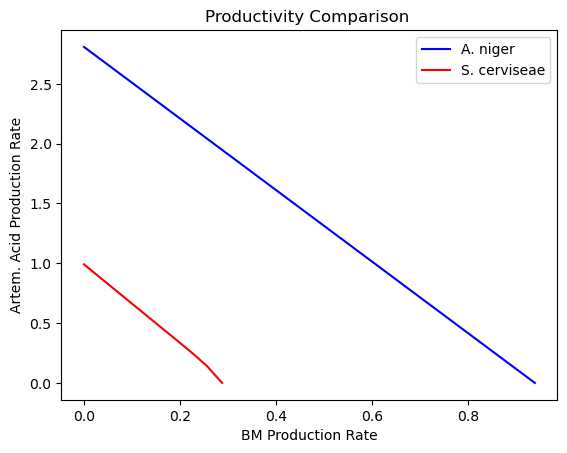

In [3]:
x1 = array_biomass
x2 = array_biomassY
y1 = array_secretion
y2 = array_secretionY

fig = plt.plot(x1, y1, color='b', label='A. niger')
fig = plt.plot(x2, y2, color='r', label='S. cerviseae')

fig = plt.legend(loc="upper right")
fig = plt.xlabel("BM Production Rate")
fig = plt.ylabel("Artem. Acid Production Rate")
fig = plt.title("Productivity Comparison ")

plt.show()

In [4]:
#see max artem. acid production for 50% BM flux
#A. niger:
with model:
    model.reactions.DRAIN_Biomass.bounds = BM_max/2, 1000
    model.objective = model.reactions.ARTA_ex
    solution = model.optimize()    
    print("A. niger artem. acid flux with 50% BM production: ",solution.fluxes.ARTA_ex)
    print("A. niger 50% BM production: ",BM_max/2)
    
#S. cervisiae:
with modelY:
    modelY.reactions.BIOMASS_SC5_notrace.bounds = BM_maxY/2, 1000
    modelY.objective = modelY.reactions.ARTA_ex
    solutionY = modelY.optimize()    
    print("S. cervisiae artem. acid flux with 50% BM production: ",solutionY.fluxes.ARTA_ex)
    print("S. cervisiae 50% BM production: ",BM_maxY/2)

A. niger artem. acid flux with 50% BM production:  1.4040671971705783
A. niger 50% BM production:  0.46992736207464514
S. cervisiae artem. acid flux with 50% BM production:  0.5190274328371834
S. cervisiae 50% BM production:  0.14393285185200877
